![Routing](../resources/RAG/5_rag_indexing_1.png)
Many RAG methods focus on dividing documents into multiple chunks and returning a certain number of chunks to the LLM during retrieval. However, block size and number are parameters prone to error. Many users find these parameters challenging to set, as inadequate context can significantly impact the results if they do not contain enough information to answer questions effectively.

# Multi-representation

![Routing](../resources/RAG/5_rag_indexing_2.png)
By combining multiple representations such as document summaries, blocks, or complete content, optimal effectiveness is achieved in both retrieval and generation processes. 
It compensates for potential deficiencies in a single representation by using different levels and granularities of representation, ranging from concise summaries to detailed documents. 

## Proposition Indexing is one implementation method of Multi-representation.
### We use LLM to summarize the original text and generate a summary.
### The summary undergoes embedding processing and is saved into a Vector Store. Simultaneously, the original text is stored in a Doc Store.
### During retrieval, based on the embedded representation of the user's question, we search the Vector Store for the corresponding summary and then return the original text.

In [1]:
! pip install langchain-qdrant qdrant-client langchain-community langchain openai pypdf

In [ ]:
from langchain_community.llms import Ollama
from dbUtils import DBUtils

dbUtils = DBUtils()
# Initialize Ollama LLM with qwen model
llm = Ollama(
    model="qwen2.5:latest",
    temperature=0.7,
    top_k=10,
    top_p=0.95,
    repeat_penalty=1.1,
    num_ctx=4096
)

embedding_model = dbUtils.get_embedding_function("ollama")


/var/folders/qj/xprrbhtn049_4mqqdmkglrqh0000gp/T/ipykernel_27684/48864621.py:6: LangChainDeprecationWarning: The class `Ollama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaLLM``.
  llm = Ollama(


In [3]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader("../data/BeigeBook_20250115.pdf")
    
    # Load all pages
ages = loader.load()

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

chain = (
    {"doc": lambda x: x.page_content}
    | ChatPromptTemplate.from_template("Summarize the following document:\n\n{doc}")
    | llm
    | StrOutputParser()
)

summaries = chain.batch(ages, {"max_concurrency": 5})

In [4]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

client = QdrantClient(":memory:")

client.create_collection(
    collection_name="summaries",
    vectors_config=VectorParams(size=768, distance=Distance.COSINE),
)

vectorstore = QdrantVectorStore(
    client=client,
    collection_name="summaries",
    embedding=embedding_model,
)



In [5]:
import uuid
from langchain_core.documents import Document
from langchain.storage import InMemoryByteStore
from langchain.retrievers.multi_vector import MultiVectorRetriever


# The storage layer for the parent documents
store = InMemoryByteStore()
id_key = "doc_id"

# The retriever
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    byte_store=store,
    id_key=id_key,
)

doc_ids = [str(uuid.uuid4()) for _ in summaries]


# Docs linked to summaries
summary_docs = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(summaries)
]

retriever.vectorstore.add_documents(summary_docs)
retriever.docstore.mset(list(zip(doc_ids, summary_docs)))



In [6]:
query = "What is 2024 economic outlook?"
sub_docs = vectorstore.similarity_search(query,k=1)
sub_docs[0]

Document(metadata={'doc_id': '08e70822-3020-4baf-a2b0-a114a80ccfc0', '_id': 'cc6228a36a104817b2e86b4f82ae83a1', '_collection_name': 'summaries'}, page_content="The document provides an overview of economic conditions across various sectors in the First District, as reported by contacts, with a focus on 2025 expectations.\n\n### Key Points:\n\n1. **Consumer Goods:**\n   - Expected revenues to increase strongly in Q1 2025 due to organic growth and recent acquisitions.\n   - Long-term optimism about continued demand despite political and macro-economic uncertainties.\n   - Concerns over increased competition from China, which could boost or harm business depending on client responses.\n\n2. **Commercial Real Estate:**\n   - Activity was mostly flat in the First District with elevated long-term interest rates limiting transactions.\n   - Borrowers favor extensions for maturing loans, hoping that long-term rates will decline.\n   - Office leasing activity remained slow, but prime Boston pro

In [7]:
retrieved_docs = retriever.get_relevant_documents(query,n_results=1)
retrieved_docs[0].page_content[0:500]

/var/folders/qj/xprrbhtn049_4mqqdmkglrqh0000gp/T/ipykernel_27684/3791815623.py:1: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retrieved_docs = retriever.get_relevant_documents(query,n_results=1)


'The document provides an overview of economic conditions across various sectors in the First District, as reported by contacts, with a focus on 2025 expectations.\n\n### Key Points:\n\n1. **Consumer Goods:**\n   - Expected revenues to increase strongly in Q1 2025 due to organic growth and recent acquisitions.\n   - Long-term optimism about continued demand despite political and macro-economic uncertainties.\n   - Concerns over increased competition from China, which could boost or harm business dependi'

# RAPTOR
RAPTOR (Recursive Abstractive Processing for Tree-Organized Retrieval) is a indexing technique that organizes documents into a hierarchical structure, enabling effective recursive abstraction and retrieval of information. 
This method organizes document data in the form of a "tree," where leaf nodes represent original documents or document blocks, and higher-level nodes represent abstracted summaries of these documents. 
The goal of RAPTOR is to enhance information retrieval efficiency through hierarchical organization, accommodating queries of different granularities.

![Routing](../resources/RAG/5_rag_indexing_3.png)

## Leaf Node Initialization The input at the lowest level (leaf nodes) can be:

### Text blocks (small paragraphs or sections within a document)
### Entire documents
### Even finer-grained data units, such as sentences or phrases.

## Embedding and Clustering 
### Generate embedding vectors for the content of each leaf node.
### Cluster the embeddings based on the similarity of document content, using methods like K-means or hierarchical clustering algorithms.

## Cluster Summarization 
### Integrate and summarize information from documents or text blocks within each cluster to generate a higher-level summary. 
### This step can utilize LLM (Large Language Model) for summarization.

## Recursive Tree 
### Construction Use the generated higher-level summaries as new inputs and repeat the steps of embedding, clustering, and summarization. 
### Continue this process recursively until a global summary at the top level is generated.

# Plotting the histogram of token counts
plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, edgecolor="black", alpha=0.7)  # Removed color parameter
plt.title("Histogram of Token Counts")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)

# Display the histogram
plt.show()  # Fixed the show() call

In [8]:
! pip install tiktoken dashscope umap

In [9]:
import matplotlib.pyplot as plt
from dashscope import get_tokenizer  # dashscope version >= 1.14.0
from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader


# Get the tokenizer object, currently only supports the Qwen series models
tokenizer = get_tokenizer('qwen-max')

def num_tokens_from_string(string: str) -> int:
    """Returns the number of tokens in a text string."""
    # Split the string into tokens and convert to token ids
    num_tokens = tokenizer.encode(string)
    return num_tokens
    len(num_tokens)




In [10]:
# LCEL docs
url = "https://python.langchain.com/docs/concepts/lcel/"
loader = RecursiveUrlLoader(
    url=url, max_depth=20, extractor=lambda x: Soup(x, "html.parser").text
)
docs = loader.load()

docs




[Document(metadata={'source': 'https://python.langchain.com/docs/concepts/lcel/', 'content_type': 'text/html; charset=utf-8', 'title': 'LangChain Expression Language (LCEL) | 🦜️🔗 LangChain', 'description': '* Runnable Interface', 'language': 'en'}, page_content='\n\n\n\n\nLangChain Expression Language (LCEL) | 🦜️🔗 LangChain\n\n\n\n\n\n\nSkip to main contentJoin us at  Interrupt: The Agent AI Conference by LangChain on May 13 & 14 in San Francisco!IntegrationsAPI ReferenceMoreContributingPeopleError referenceLangSmithLangGraphLangChain HubLangChain JS/TSv0.3v0.3v0.2v0.1💬SearchIntroductionTutorialsBuild a Question Answering application over a Graph DatabaseTutorialsBuild a simple LLM application with chat models and prompt templatesBuild a ChatbotBuild a Retrieval Augmented Generation (RAG) App: Part 2Build an Extraction ChainBuild an AgentTaggingBuild a Retrieval Augmented Generation (RAG) App: Part 1Build a semantic search engineBuild a Question/Answering system over SQL dataSummarize 

In [11]:
# LCEL w/ PydanticOutputParser (outside the primary LCEL docs)
url = "https://python.langchain.com/docs/how_to/output_parser_structured/"
loader = RecursiveUrlLoader(
    url=url, max_depth=1, extractor=lambda x: Soup(x, "html.parser").text
)
docs_pydantic = loader.load()

docs_pydantic

[Document(metadata={'source': 'https://python.langchain.com/docs/how_to/output_parser_structured/', 'content_type': 'text/html; charset=utf-8', 'title': 'How to use output parsers to parse an LLM response into structured format | 🦜️🔗 LangChain', 'description': 'Language models output text. But there are times where you want to get more structured information than just text back. While some model providers support built-in ways to return structured output, not all do.', 'language': 'en'}, page_content='\n\n\n\n\nHow to use output parsers to parse an LLM response into structured format | 🦜️🔗 LangChain\n\n\n\n\n\n\nSkip to main contentJoin us at  Interrupt: The Agent AI Conference by LangChain on May 13 & 14 in San Francisco!IntegrationsAPI ReferenceMoreContributingPeopleError referenceLangSmithLangGraphLangChain HubLangChain JS/TSv0.3v0.3v0.2v0.1💬SearchIntroductionTutorialsBuild a Question Answering application over a Graph DatabaseTutorialsBuild a simple LLM application with chat models

In [12]:
# LCEL w/ Self Query (outside the primary LCEL docs)
url = "https://python.langchain.com/docs/how_to/self_query/"
loader = RecursiveUrlLoader(
    url=url, max_depth=1, extractor=lambda x: Soup(x, "html.parser").text
)
docs_sq = loader.load()

docs_sq

[Document(metadata={'source': 'https://python.langchain.com/docs/how_to/self_query/', 'content_type': 'text/html; charset=utf-8', 'title': 'How to do "self-querying" retrieval | 🦜️🔗 LangChain', 'description': 'Head to Integrations for documentation on vector stores with built-in support for self-querying.', 'language': 'en'}, page_content='\n\n\n\n\nHow to do "self-querying" retrieval | 🦜️🔗 LangChain\n\n\n\n\n\n\nSkip to main contentJoin us at  Interrupt: The Agent AI Conference by LangChain on May 13 & 14 in San Francisco!IntegrationsAPI ReferenceMoreContributingPeopleError referenceLangSmithLangGraphLangChain HubLangChain JS/TSv0.3v0.3v0.2v0.1💬SearchIntroductionTutorialsBuild a Question Answering application over a Graph DatabaseTutorialsBuild a simple LLM application with chat models and prompt templatesBuild a ChatbotBuild a Retrieval Augmented Generation (RAG) App: Part 2Build an Extraction ChainBuild an AgentTaggingBuild a Retrieval Augmented Generation (RAG) App: Part 1Build a s

In [13]:
# Doc texts
docs.extend([*docs_pydantic, *docs_sq])

docs_texts = [d.page_content for d in docs]

print(docs_texts)

# Calculate the number of tokens for each document
counts = [num_tokens_from_string(doc_text) for doc_text in docs_texts]

counts



['\n\n\n\n\nLangChain Expression Language (LCEL) | 🦜️🔗 LangChain\n\n\n\n\n\n\nSkip to main contentJoin us at  Interrupt: The Agent AI Conference by LangChain on May 13 & 14 in San Francisco!IntegrationsAPI ReferenceMoreContributingPeopleError referenceLangSmithLangGraphLangChain HubLangChain JS/TSv0.3v0.3v0.2v0.1💬SearchIntroductionTutorialsBuild a Question Answering application over a Graph DatabaseTutorialsBuild a simple LLM application with chat models and prompt templatesBuild a ChatbotBuild a Retrieval Augmented Generation (RAG) App: Part 2Build an Extraction ChainBuild an AgentTaggingBuild a Retrieval Augmented Generation (RAG) App: Part 1Build a semantic search engineBuild a Question/Answering system over SQL dataSummarize TextHow-to guidesHow-to guidesHow to use tools in a chainHow to use a vectorstore as a retrieverHow to add memory to chatbotsHow to use example selectorsHow to add a semantic layer over graph databaseHow to invoke runnables in parallelHow to stream chat model r

[[14621,
  26223,
  18837,
  16378,
  11434,
  320,
  43,
  41664,
  8,
  760,
  11162,
  99,
  250,
  30543,
  146450,
  22463,
  18837,
  34583,
  35134,
  311,
  1887,
  2213,
  12292,
  601,
  518,
  220,
  22145,
  25,
  576,
  20713,
  15235,
  14872,
  553,
  22463,
  18837,
  389,
  3217,
  220,
  16,
  18,
  609,
  220,
  16,
  19,
  304,
  5836,
  12879,
  0,
  1072,
  14412,
  804,
  7082,
  17207,
  7661,
  52984,
  10607,
  15919,
  1454,
  5785,
  26223,
  41885,
  26223,
  11212,
  26223,
  18837,
  26538,
  26223,
  18837,
  12162,
  14,
  9951,
  85,
  15,
  13,
  18,
  85,
  15,
  13,
  18,
  85,
  15,
  13,
  17,
  85,
  15,
  13,
  16,
  145653,
  5890,
  37155,
  51,
  54927,
  11066,
  264,
  15846,
  21806,
  287,
  3766,
  916,
  264,
  12165,
  9994,
  51,
  54927,
  11066,
  264,
  4285,
  444,
  10994,
  3766,
  448,
  6236,
  4119,
  323,
  9934,
  19911,
  11066,
  264,
  12853,
  6331,
  11066,
  264,
  19470,
  831,
  4928,
  26980,
  23470,
  320,
  49,


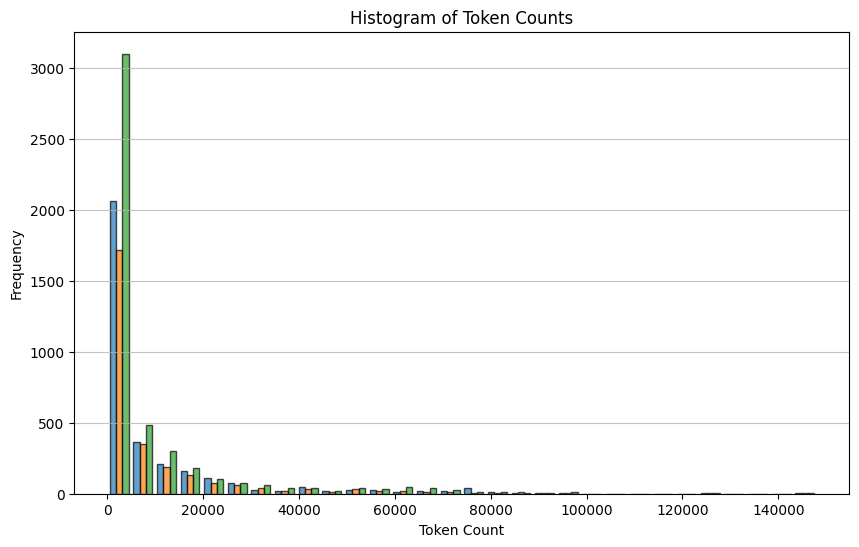

In [14]:
# Plotting the histogram of token counts
plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, edgecolor="black", alpha=0.7)
plt.title("Histogram of Token Counts")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)

# # Display the histogram
plt.show()

In [15]:
# Doc texts concat
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)
print(f"Num tokens in all context: {num_tokens_from_string(concatenated_content)}")

Num tokens in all context: [14621, 4340, 311, 653, 330, 721, 65489, 287, 1, 56370, 760, 11162, 99, 250, 30543, 146450, 22463, 18837, 34583, 35134, 311, 1887, 2213, 12292, 601, 518, 220, 22145, 25, 576, 20713, 15235, 14872, 553, 22463, 18837, 389, 3217, 220, 16, 18, 609, 220, 16, 19, 304, 5836, 12879, 0, 1072, 14412, 804, 7082, 17207, 7661, 52984, 10607, 15919, 1454, 5785, 26223, 41885, 26223, 11212, 26223, 18837, 26538, 26223, 18837, 12162, 14, 9951, 85, 15, 13, 18, 85, 15, 13, 18, 85, 15, 13, 17, 85, 15, 13, 16, 145653, 5890, 37155, 51, 54927, 11066, 264, 15846, 21806, 287, 3766, 916, 264, 12165, 9994, 51, 54927, 11066, 264, 4285, 444, 10994, 3766, 448, 6236, 4119, 323, 9934, 19911, 11066, 264, 12853, 6331, 11066, 264, 19470, 831, 4928, 26980, 23470, 320, 49, 1890, 8, 1845, 25, 3660, 220, 17, 11066, 458, 94506, 28525, 11066, 458, 20713, 5668, 3173, 11066, 264, 19470, 831, 4928, 26980, 23470, 320, 49, 1890, 8, 1845, 25, 3660, 220, 16, 11066, 264, 41733, 2711, 4712, 11066, 264, 15846, 1

In [16]:
# Doc texts split
from langchain.text_splitter import RecursiveCharacterTextSplitter

chunk_size_tok = 2000
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=chunk_size_tok, chunk_overlap=0
)
texts_split = text_splitter.split_text(concatenated_content)

In [17]:
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import umap
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from sklearn.mixture import GaussianMixture

RANDOM_SEED = 224  # Fixed seed for reproducibility

### --- Code from 
# https://github.com/parthsarthi03/raptor/blob/master/raptor/cluster_tree_builder.py
# https://github.com/run-llama/llama_index/blob/main/llama-index-packs/llama-index-packs-raptor/llama_index/packs/raptor/clustering.py 
# (added comments and docstrings) --- ###


def global_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    """
    Perform global dimensionality reduction on the embeddings using UMAP.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for the reduced space.
    - n_neighbors: Optional; the number of neighbors to consider for each point.
                   If not provided, it defaults to the square root of the number of embeddings.
    - metric: The distance metric to use for UMAP.

    Returns:
    - A numpy array of the embeddings reduced to the specified dimensionality.
    """
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


def local_cluster_embeddings(
    embeddings: np.ndarray, dim: int, num_neighbors: int = 10, metric: str = "cosine"
) -> np.ndarray:
    """
    Perform local dimensionality reduction on the embeddings using UMAP, typically after global clustering.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for the reduced space.
    - num_neighbors: The number of neighbors to consider for each point.
    - metric: The distance metric to use for UMAP.

    Returns:
    - A numpy array of the embeddings reduced to the specified dimensionality.
    """
    return umap.UMAP(
        n_neighbors=num_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


def get_optimal_clusters(
    embeddings: np.ndarray, max_clusters: int = 50, random_state: int = RANDOM_SEED
) -> int:
    """
    Determine the optimal number of clusters using the Bayesian Information Criterion (BIC) with a Gaussian Mixture Model.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - max_clusters: The maximum number of clusters to consider.
    - random_state: Seed for reproducibility.

    Returns:
    - An integer representing the optimal number of clusters found.
    """
    max_clusters = min(max_clusters, len(embeddings))
    n_clusters = np.arange(1, max_clusters)
    bics = []
    for n in n_clusters:
        gm = GaussianMixture(n_components=n, random_state=random_state)
        gm.fit(embeddings)
        bics.append(gm.bic(embeddings))
    return n_clusters[np.argmin(bics)]


def GMM_cluster(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    """
    Cluster embeddings using a Gaussian Mixture Model (GMM) based on a probability threshold.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - threshold: The probability threshold for assigning an embedding to a cluster.
    - random_state: Seed for reproducibility.

    Returns:
    - A tuple containing the cluster labels and the number of clusters determined.
    """
    n_clusters = get_optimal_clusters(embeddings)
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state)
    gm.fit(embeddings)
    probs = gm.predict_proba(embeddings)
    labels = [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters


def perform_clustering(
    embeddings: np.ndarray,
    dim: int,
    threshold: float,
) -> List[np.ndarray]:
    """
    Perform clustering on the embeddings by first reducing their dimensionality globally, then clustering
    using a Gaussian Mixture Model, and finally performing local clustering within each global cluster.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for UMAP reduction.
    - threshold: The probability threshold for assigning an embedding to a cluster in GMM.

    Returns:
    - A list of numpy arrays, where each array contains the cluster IDs for each embedding.
    """
    if len(embeddings) <= dim + 1:
        # Avoid clustering when there's insufficient data
        return [np.array([0]) for _ in range(len(embeddings))]

    # Global dimensionality reduction
    reduced_embeddings_global = global_cluster_embeddings(embeddings, dim)
    # Global clustering
    global_clusters, n_global_clusters = GMM_cluster(
        reduced_embeddings_global, threshold
    )

    all_local_clusters = [np.array([]) for _ in range(len(embeddings))]
    total_clusters = 0

    # Iterate through each global cluster to perform local clustering
    for i in range(n_global_clusters):
        # Extract embeddings belonging to the current global cluster
        global_cluster_embeddings_ = embeddings[
            np.array([i in gc for gc in global_clusters])
        ]

        if len(global_cluster_embeddings_) == 0:
            continue
        if len(global_cluster_embeddings_) <= dim + 1:
            # Handle small clusters with direct assignment
            local_clusters = [np.array([0]) for _ in global_cluster_embeddings_]
            n_local_clusters = 1
        else:
            # Local dimensionality reduction and clustering
            reduced_embeddings_local = local_cluster_embeddings(
                global_cluster_embeddings_, dim
            )
            local_clusters, n_local_clusters = GMM_cluster(
                reduced_embeddings_local, threshold
            )

        # Assign local cluster IDs, adjusting for total clusters already processed
        for j in range(n_local_clusters):
            local_cluster_embeddings_ = global_cluster_embeddings_[
                np.array([j in lc for lc in local_clusters])
            ]
            indices = np.where(
                (embeddings == local_cluster_embeddings_[:, None]).all(-1)
            )[1]
            for idx in indices:
                all_local_clusters[idx] = np.append(
                    all_local_clusters[idx], j + total_clusters
                )

        total_clusters += n_local_clusters

    return all_local_clusters


### --- Our code below --- ###


def embed(texts):
    """
    Generate embeddings for a list of text documents.

    This function assumes the existence of an `embedding_model` object with a method `embed_documents`
    that takes a list of texts and returns their embeddings.

    Parameters:
    - texts: List[str], a list of text documents to be embedded.

    Returns:
    - numpy.ndarray: An array of embeddings for the given text documents.
    """
    text_embeddings = embedding_model.embed_documents(texts)
    text_embeddings_np = np.array(text_embeddings)
    return text_embeddings_np


def embed_cluster_texts(texts):
    """
    Embeds a list of texts and clusters them, returning a DataFrame with texts, their embeddings, and cluster labels.

    This function combines embedding generation and clustering into a single step. It assumes the existence
    of a previously defined `perform_clustering` function that performs clustering on the embeddings.

    Parameters:
    - texts: List[str], a list of text documents to be processed.

    Returns:
    - pandas.DataFrame: A DataFrame containing the original texts, their embeddings, and the assigned cluster labels.
    """
    text_embeddings_np = embed(texts)  # Generate embeddings
    cluster_labels = perform_clustering(
        text_embeddings_np, 10, 0.1
    )  # Perform clustering on the embeddings
    df = pd.DataFrame()  # Initialize a DataFrame to store the results
    df["text"] = texts  # Store original texts
    df["embd"] = list(text_embeddings_np)  # Store embeddings as a list in the DataFrame
    df["cluster"] = cluster_labels  # Store cluster labels
    return df


def fmt_txt(df: pd.DataFrame) -> str:
    """
    Formats the text documents in a DataFrame into a single string.

    Parameters:
    - df: DataFrame containing the 'text' column with text documents to format.

    Returns:
    - A single string where all text documents are joined by a specific delimiter.
    """
    unique_txt = df["text"].tolist()
    return "--- --- \n --- --- ".join(unique_txt)


def embed_cluster_summarize_texts(
    texts: List[str], level: int
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Embeds, clusters, and summarizes a list of texts. This function first generates embeddings for the texts,
    clusters them based on similarity, expands the cluster assignments for easier processing, and then summarizes
    the content within each cluster.

    Parameters:
    - texts: A list of text documents to be processed.
    - level: An integer parameter that could define the depth or detail of processing.

    Returns:
    - Tuple containing two DataFrames:
      1. The first DataFrame (`df_clusters`) includes the original texts, their embeddings, and cluster assignments.
      2. The second DataFrame (`df_summary`) contains summaries for each cluster, the specified level of detail,
         and the cluster identifiers.
    """

    # Embed and cluster the texts, resulting in a DataFrame with 'text', 'embd', and 'cluster' columns
    df_clusters = embed_cluster_texts(texts)

    # Prepare to expand the DataFrame for easier manipulation of clusters
    expanded_list = []

    # Expand DataFrame entries to document-cluster pairings for straightforward processing
    for index, row in df_clusters.iterrows():
        for cluster in row["cluster"]:
            expanded_list.append(
                {"text": row["text"], "embd": row["embd"], "cluster": cluster}
            )

    # Create a new DataFrame from the expanded list
    expanded_df = pd.DataFrame(expanded_list)

    # Retrieve unique cluster identifiers for processing
    all_clusters = expanded_df["cluster"].unique()

    print(f"--Generated {len(all_clusters)} clusters--")

    # Summarization
    template = """Here is a sub-set of LangChain Expression Langauge doc.

    LangChain Expression Langauge provides a way to compose chain in LangChain.

    Give a detailed summary of the documentation provided.

    Documentation:
    {context}
    """
    prompt = ChatPromptTemplate.from_template(template)
    chain = prompt | llm | StrOutputParser()

    # Format text within each cluster for summarization
    summaries = []
    for i in all_clusters:
        df_cluster = expanded_df[expanded_df["cluster"] == i]
        formatted_txt = fmt_txt(df_cluster)
        summaries.append(chain.invoke({"context": formatted_txt}))

    # Create a DataFrame to store summaries with their corresponding cluster and level
    df_summary = pd.DataFrame(
        {
            "summaries": summaries,
            "level": [level] * len(summaries),
            "cluster": list(all_clusters),
        }
    )

    return df_clusters, df_summary


def recursive_embed_cluster_summarize(
    texts: List[str], level: int = 1, n_levels: int = 3
) -> Dict[int, Tuple[pd.DataFrame, pd.DataFrame]]:
    """
    Recursively embeds, clusters, and summarizes texts up to a specified level or until
    the number of unique clusters becomes 1, storing the results at each level.

    Parameters:
    - texts: List[str], texts to be processed.
    - level: int, current recursion level (starts at 1).
    - n_levels: int, maximum depth of recursion.

    Returns:
    - Dict[int, Tuple[pd.DataFrame, pd.DataFrame]], a dictionary where keys are the recursion
      levels and values are tuples containing the clusters DataFrame and summaries DataFrame at that level.
    """
    results = {}  # Dictionary to store results at each level

    # Perform embedding, clustering, and summarization for the current level
    df_clusters, df_summary = embed_cluster_summarize_texts(texts, level)

    # Store the results of the current level
    results[level] = (df_clusters, df_summary)

    # Determine if further recursion is possible and meaningful
    unique_clusters = df_summary["cluster"].nunique()
    if level < n_levels and unique_clusters > 1:
        # Use summaries as the input texts for the next level of recursion
        new_texts = df_summary["summaries"].tolist()
        next_level_results = recursive_embed_cluster_summarize(
            new_texts, level + 1, n_levels
        )

        # Merge the results from the next level into the current results dictionary
        results.update(next_level_results)

    return results

In [18]:
docs_texts

['\n\n\n\n\nLangChain Expression Language (LCEL) | 🦜️🔗 LangChain\n\n\n\n\n\n\nSkip to main contentJoin us at  Interrupt: The Agent AI Conference by LangChain on May 13 & 14 in San Francisco!IntegrationsAPI ReferenceMoreContributingPeopleError referenceLangSmithLangGraphLangChain HubLangChain JS/TSv0.3v0.3v0.2v0.1💬SearchIntroductionTutorialsBuild a Question Answering application over a Graph DatabaseTutorialsBuild a simple LLM application with chat models and prompt templatesBuild a ChatbotBuild a Retrieval Augmented Generation (RAG) App: Part 2Build an Extraction ChainBuild an AgentTaggingBuild a Retrieval Augmented Generation (RAG) App: Part 1Build a semantic search engineBuild a Question/Answering system over SQL dataSummarize TextHow-to guidesHow-to guidesHow to use tools in a chainHow to use a vectorstore as a retrieverHow to add memory to chatbotsHow to use example selectorsHow to add a semantic layer over graph databaseHow to invoke runnables in parallelHow to stream chat model r

In [19]:
# Build tree
leaf_texts = docs_texts
results = recursive_embed_cluster_summarize(leaf_texts, level=1, n_levels=3)

--Generated 1 clusters--


In [20]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

client = QdrantClient(":memory:")

client.create_collection(
    collection_name="raptor",
    vectors_config=VectorParams(size=768, distance=Distance.COSINE),
)

vector_store = QdrantVectorStore(
    client=client,
    collection_name="raptor",
    embedding=embedding_model,
)

# Initialize all_texts with leaf_texts
all_texts = leaf_texts.copy()

# Iterate through the results to extract summaries from each level and add them to all_texts
for level in sorted(results.keys()):
    # Extract summaries from the current level's DataFrame
    summaries = results[level][1]["summaries"].tolist()
    # Extend all_texts with the summaries from the current level
    all_texts.extend(summaries)

vector_store.add_texts(texts=all_texts)

retriever = vector_store.as_retriever()

In [21]:
retriever

VectorStoreRetriever(tags=['QdrantVectorStore', 'OllamaEmbeddings'], vectorstore=<langchain_qdrant.qdrant.QdrantVectorStore object at 0x31dd25fd0>, search_kwargs={})

In [22]:
from langchain import hub
from langchain_core.runnables import RunnablePassthrough

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# Post-processing
def format_docs(docs):
    print(docs)
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

# Question
rag_chain.invoke("HWhat is LangChain Expression Language? Give me a specific code example.")

/Users/easonyin/miniconda3/lib/python3.12/site-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


[Document(metadata={'_id': '2e180894119b4f3c8968358617155dff', '_collection_name': 'raptor'}, page_content='This guide provides a comprehensive overview of creating and using a self-querying retriever in LangChain. Let\'s break down the key steps and concepts involved:\n\n### Key Concepts\n\n1. **Query Construction**:\n   - The query is transformed into a structured form that includes both text content to match against document contents and metadata filters.\n   - This involves generating a `StructuredQuery` object which contains the textual search term (`query`) and the logical conditions on metadata fields (`filter`).\n\n2. **Prompt and Output Parser**:\n   - A prompt is provided for constructing the structured query, which includes examples of how to format the query.\n   - An output parser translates the structured query into a form that can be understood by the retrieval system.\n\n3. **StructuredQueryTranslator**:\n   - This component converts the structured query into a filter s

'Based on the information provided in the prompt and the context of your query, it seems you are looking to understand how to use LCEL (LangChain Expression Language) for building chains or runnables. Here\'s a summary of key points and examples that can help you get started:\n\n### Benefits of LCEL\n\n1. **Optimized Parallel Execution**: Run multiple Runnables in parallel using `RunnableParallel`.\n2. **Guaranteed Async Support**: Asynchronous execution with the `RunnableAsync` API.\n3. **Simplified Streaming**: Incremental output as chains are executed.\n\n### Composition Primitives\n\n1. **RunnableSequence**:\n   - **Usage**: Sequentially chain multiple runnables.\n   ```python\n   from langchain_core.runnables import RunnableSequence\n\n   chain = RunnableSequence([runnable1, runnable2])\n   final_output = chain.invoke(some_input)\n   ```\n\n2. **RunnableParallel**:\n   - **Usage**: Run multiple runnables concurrently with the same input.\n   ```python\n   from langchain_core.runna